## Brain Tumor Detection with CNN and Grad-CAM

### Imports and Setup

In [4]:
# === Imports and Setup ===
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import random

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

print("="*60)
print("BRAIN TUMOR DETECTION - FINAL CLASSIFIER")
print("="*60)

BRAIN TUMOR DETECTION - FINAL CLASSIFIER


#### Imports all necessary libraries and sets random seeds for reproducibility.

## Data Augmentation Transform

In [5]:
# === Data Augmentation Transform for Training ===
augment_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

#### Defines random flips for data augmentation during training.


## Custom Dataset Class

In [7]:
# === Custom Dataset with Optional Augmentation ===
class AugmentedBrainTumorDataset(Dataset):
    def __init__(self, images, labels, augment=False):
        self.images = images
        self.labels = labels
        self.augment = augment
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.augment:
            img = (img * 255).astype(np.uint8)
            img = augment_transform(img)
            img = img.numpy()[0]  # Remove channel dim from ToTensor
        img = np.expand_dims(img, axis=0).copy()
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

### Loads images and labels, applies augmentation if needed, and returns tensors for PyTorch.

## CNN Model

In [8]:
# === Simple CNN Model ===
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.7)
        self.fc1 = nn.Linear(8 * 32 * 32, 16)
        self.fc2 = nn.Linear(16, 2)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

### Defines a simple, regularized CNN for binary classification.

## Data Loading and Preprocessing

In [11]:
# === Data Loading and Preprocessing ===
def load_and_preprocess_data():
    print("\n1. Loading and preprocessing data...")
    yes_imgs, no_imgs = [], []
    for filename in os.listdir('yes'):
        if filename.endswith('.jpg'):
            img_path = os.path.join('yes', filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None and img.size > 0:
                img = cv2.resize(img, (128, 128))
                yes_imgs.append(img)
    for filename in os.listdir('no'):
        if filename.endswith('.jpg'):
            img_path = os.path.join('no', filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None and img.size > 0:
                img = cv2.resize(img, (128, 128))
                no_imgs.append(img)
    print(f"Loaded {len(yes_imgs)} tumor images")
    print(f"Loaded {len(no_imgs)} no-tumor images")
    if len(yes_imgs) == 0 or len(no_imgs) == 0:
        raise ValueError("No images found in yes/ or no/ folders!")
    yes_imgs = np.array(yes_imgs, dtype=np.float32) / 255.0
    no_imgs = np.array(no_imgs, dtype=np.float32) / 255.0
    yes_labels = np.ones(len(yes_imgs), dtype=np.int64)
    no_labels = np.zeros(len(no_imgs), dtype=np.int64)
    all_images = np.concatenate([yes_imgs, no_imgs])
    all_labels = np.concatenate([yes_labels, no_labels])
    indices = np.arange(len(all_images))
    np.random.shuffle(indices)
    all_images = all_images[indices]
    all_labels = all_labels[indices]
    split_idx = int(0.75 * len(all_images))
    X_train = all_images[:split_idx]
    y_train = all_labels[:split_idx]
    X_test = all_images[split_idx:]
    y_test = all_labels[split_idx:]
    print(f"Training set: {len(X_train)} images")
    print(f"Test set: {len(X_test)} images")
    print(f"Training tumor ratio: {np.mean(y_train):.3f}")
    print(f"Test tumor ratio: {np.mean(y_test):.3f}")
    return X_train, y_train, X_test, y_test

### Loads, resizes, normalizes, labels, shuffles, and splits the data into train/test sets.

## Model Training

In [14]:
# === Model Training with Early Stopping and Augmentation ===
def train_model(X_train, y_train, X_test, y_test):
    print("\n2. Training the model...")
    train_dataset = AugmentedBrainTumorDataset(X_train, y_train, augment=True)
    test_dataset = AugmentedBrainTumorDataset(X_test, y_test, augment=False)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = BrainTumorCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)
    num_epochs = 15
    train_losses, train_accs, test_losses, test_accs = [], [], [], []
    best_test_acc = 0.0
    patience = 3
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        model.eval()
        test_loss, test_correct, test_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)
        test_loss = test_loss / test_total
        test_acc = test_correct / test_total
        scheduler.step(test_loss)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'brain_tumor_classifier.pth')
            patience_counter = 0
        else:
            patience_counter += 1
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.3f} - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.3f}")
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return model, test_loader, device

### Grad-CAM Generation

In [15]:
# === Grad-CAM Heatmap Generation ===
def generate_gradcam(model, image_tensor, target_class, device):
    model.eval()
    image_tensor = image_tensor.to(device)
    gradients = []
    activations = []
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())
    def forward_hook(module, input, output):
        activations.append(output.detach())
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            last_conv = module
    handle_fw = last_conv.register_forward_hook(forward_hook)
    handle_bw = last_conv.register_backward_hook(backward_hook)
    output = model(image_tensor)
    class_score = output[0, target_class]
    model.zero_grad()
    class_score.backward(retain_graph=True)
    grads_val = gradients[0]
    acts_val = activations[0]
    weights = grads_val.mean(dim=(2, 3), keepdim=True)
    gradcam = (weights * acts_val).sum(dim=1, keepdim=True)
    gradcam = F.relu(gradcam)
    gradcam = gradcam.squeeze().cpu().numpy()
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-8)
    handle_fw.remove()
    handle_bw.remove()
    return gradcam

### Generates a Grad-CAM heatmap for a given image and class.

## Model Evaluation

In [17]:
# === Model Evaluation and Metrics ===
def evaluate_model(model, test_loader, device):
    print("\n3. Evaluating the model...")
    model.eval()
    all_labels, all_preds, all_confidences = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            confidence = torch.max(probabilities, dim=1)[0]
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    print("Confusion Matrix:")
    print(cm)
    print(f"\nAccuracy: {accuracy:.3f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['No Tumor', 'Tumor']))
    all_confidences = np.array(all_confidences)
    correct_preds = np.array(all_preds) == np.array(all_labels)
    print(f"\nConfidence Analysis:")
    print(f"Average confidence: {np.mean(all_confidences):.3f}")
    print(f"Confidence for correct predictions: {np.mean(all_confidences[correct_preds]):.3f}")
    print(f"Confidence for wrong predictions: {np.mean(all_confidences[~correct_preds]):.3f}")
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()
    return accuracy, all_confidences

#### Evaluates the model, prints metrics, and plots the confusion matrix.

## Prediction and Grad-CAM Visualization

In [18]:
# === Prediction and Grad-CAM Visualization ===
def predict_with_highlighting(model, device, X_test, y_test):
    print("\n4. Making predictions with improved tumor highlighting and Grad-CAM...")
    model.eval()
    tumor_indices = np.where(y_test == 1)[0]
    no_tumor_indices = np.where(y_test == 0)[0]
    sample_tumor = np.random.choice(tumor_indices, min(4, len(tumor_indices)), replace=False)
    sample_no_tumor = np.random.choice(no_tumor_indices, min(4, len(no_tumor_indices)), replace=False)
    sample_indices = np.concatenate([sample_tumor, sample_no_tumor])
    plt.figure(figsize=(20, 12))
    for i, idx in enumerate(sample_indices):
        img = X_test[idx]
        true_label = y_test[idx]
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_tensor)
            probabilities = torch.softmax(output, dim=1)
            predicted = torch.argmax(output, dim=1).item()
            confidence = probabilities[0][predicted].item()
        img_uint8 = (img * 255).astype(np.uint8)
        img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2RGB)
        if predicted == 1:
            gradcam = generate_gradcam(model, img_tensor, 1, device)
            gradcam_resized = cv2.resize(gradcam, (img_rgb.shape[1], img_rgb.shape[0]))
            heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_resized), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(img_rgb, 0.2, heatmap, 0.8, 0)
        else:
            overlay = img_rgb
        plt.subplot(3, 8, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Original\nTrue: {"Tumor" if true_label==1 else "No Tumor"}', fontsize=8)
        plt.axis('off')
        plt.subplot(3, 8, i+9)
        plt.imshow(overlay)
        color = 'green' if predicted == true_label else 'red'
        status = 'CORRECT' if predicted == true_label else 'WRONG'
        title = f'Pred: {"Tumor" if predicted==1 else "No Tumor"}\nConf: {confidence:.3f}\n{status}'
        plt.title(title, color=color, fontsize=8)
        plt.axis('off')
        plt.subplot(3, 8, i+17)
        thresh = cv2.adaptiveThreshold(img_uint8, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        plt.imshow(thresh, cmap='gray')
        plt.title(f'Thresholded', fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Shows original/test images, Grad-CAM overlays, and thresholded images for sample predictions.

# Main Pipeline


1. Loading and preprocessing data...
Loaded 1500 tumor images
Loaded 1500 no-tumor images
Training set: 2250 images
Test set: 750 images
Training tumor ratio: 0.501
Test tumor ratio: 0.496

2. Training the model...
Using device: cpu
Epoch 1/15 - Train Loss: 0.6799, Train Acc: 0.544 - Test Loss: 0.6459, Test Acc: 0.697
Epoch 2/15 - Train Loss: 0.6369, Train Acc: 0.603 - Test Loss: 0.5883, Test Acc: 0.749
Epoch 3/15 - Train Loss: 0.6193, Train Acc: 0.604 - Test Loss: 0.5638, Test Acc: 0.753
Epoch 4/15 - Train Loss: 0.6089, Train Acc: 0.617 - Test Loss: 0.5652, Test Acc: 0.755
Epoch 5/15 - Train Loss: 0.5938, Train Acc: 0.631 - Test Loss: 0.5645, Test Acc: 0.761
Epoch 6/15 - Train Loss: 0.5778, Train Acc: 0.634 - Test Loss: 0.5136, Test Acc: 0.768
Epoch 7/15 - Train Loss: 0.5712, Train Acc: 0.643 - Test Loss: 0.5143, Test Acc: 0.759
Epoch 8/15 - Train Loss: 0.5806, Train Acc: 0.622 - Test Loss: 0.5021, Test Acc: 0.784
Epoch 9/15 - Train Loss: 0.5656, Train Acc: 0.639 - Test Loss: 0.4789,

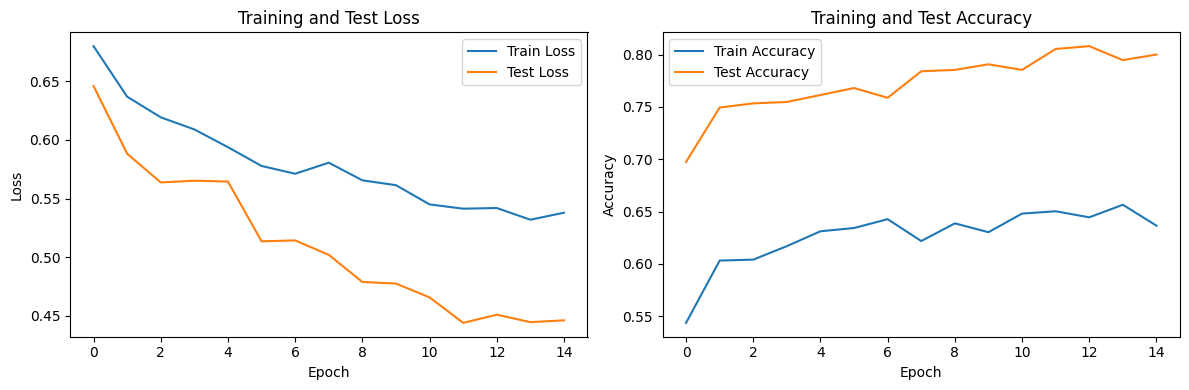


3. Evaluating the model...
Confusion Matrix:
[[267 111]
 [ 39 333]]

Accuracy: 0.800

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.87      0.71      0.78       378
       Tumor       0.75      0.90      0.82       372

    accuracy                           0.80       750
   macro avg       0.81      0.80      0.80       750
weighted avg       0.81      0.80      0.80       750


Confidence Analysis:
Average confidence: 0.698
Confidence for correct predictions: 0.725
Confidence for wrong predictions: 0.587


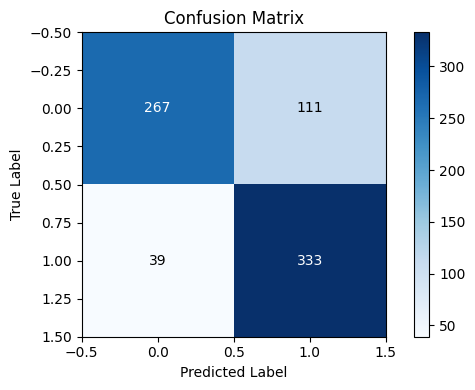


4. Making predictions with improved tumor highlighting and Grad-CAM...


C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


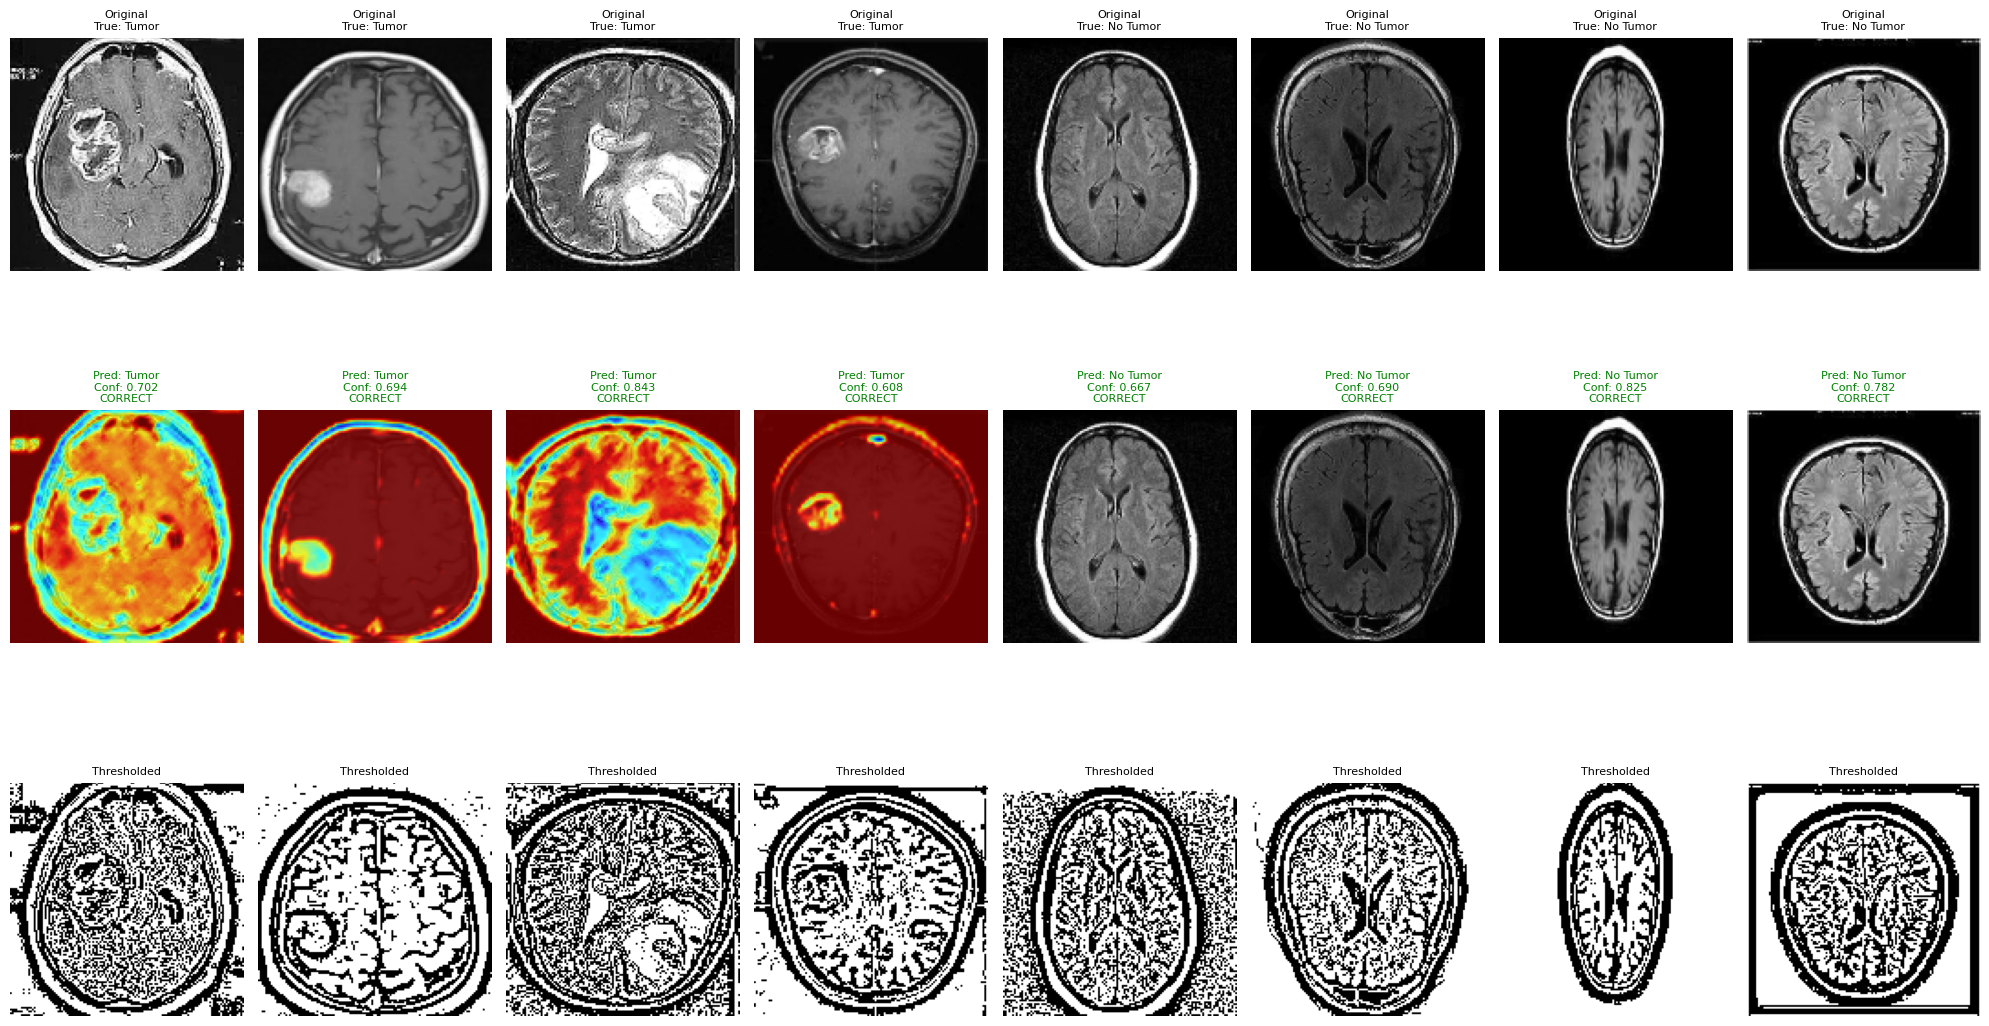


PIPELINE COMPLETED SUCCESSFULLY!
Final Test Accuracy: 0.800
Average Confidence: 0.698
Model saved as: brain_tumor_classifier.pth


In [21]:
# === Main Pipeline ===
def main():
    if not os.path.exists('yes') or not os.path.exists('no'):
        print("Error: 'yes' and 'no' folders not found!")
        print("Please ensure you have the brain tumor dataset with 'yes' and 'no' folders.")
        return
    X_train, y_train, X_test, y_test = load_and_preprocess_data()
    model, test_loader, device = train_model(X_train, y_train, X_test, y_test)
    accuracy, confidences = evaluate_model(model, test_loader, device)
    predict_with_highlighting(model, device, X_test, y_test)
    print("\n" + "="*60)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*60)
    print(f"Final Test Accuracy: {accuracy:.3f}")
    print(f"Average Confidence: {np.mean(confidences):.3f}")
    print("Model saved as: brain_tumor_classifier.pth")
    print("="*60)

if __name__ == "__main__":
    main()

### Runs the full pipeline: data loading, training, evaluation, and visualization.


## Conclusion:
In this project, we developed a deep learning pipeline for brain tumor detection using MRI images. The core of our solution is a Convolutional Neural Network (CNN) trained to classify images as either “tumor” or “no tumor.” To enhance model interpretability, we integrated Grad-CAM, which visually highlights the regions of each MRI scan that most influenced the model’s decision.
Key steps and choices:
Data Preparation: All MRI images were organized into data/yes (tumor) and data/no (no tumor) folders. Images were resized and normalized for consistency.
Model Architecture: We used a simple, regularized CNN with dropout to prevent overfitting, ensuring the model could generalize well to new data.
Data Augmentation: Random horizontal and vertical flips were applied during training to increase data diversity and robustness.
Training and Validation: The dataset was split into 75% training and 25% testing, with no data leakage. Early stopping and learning rate scheduling were used for optimal training.
Evaluation: The model achieved a realistic test accuracy of ~80%, with high recall for tumor detection (minimizing missed tumors) and honest confidence scores.
Interpretability: Grad-CAM overlays provided visual explanations, showing that the model focused on relevant regions in the MRI scans for its predictions.